Data saved to 'LSTM_signals.csv' successfully.
Epoch 1/50
58/58 [==============================] - 4s 18ms/step - loss: 0.6954 - accuracy: 0.5122 - val_loss: 0.6866 - val_accuracy: 0.5833
Epoch 2/50
58/58 [==============================] - 0s 7ms/step - loss: 0.6912 - accuracy: 0.5052 - val_loss: 0.6848 - val_accuracy: 0.5694
Epoch 3/50
58/58 [==============================] - 0s 8ms/step - loss: 0.6906 - accuracy: 0.5296 - val_loss: 0.6841 - val_accuracy: 0.5625
Epoch 4/50
58/58 [==============================] - 0s 8ms/step - loss: 0.6901 - accuracy: 0.5314 - val_loss: 0.6843 - val_accuracy: 0.5833
Epoch 5/50
58/58 [==============================] - 1s 9ms/step - loss: 0.6915 - accuracy: 0.5418 - val_loss: 0.6844 - val_accuracy: 0.5764
Epoch 6/50
58/58 [==============================] - 0s 7ms/step - loss: 0.6911 - accuracy: 0.5314 - val_loss: 0.6829 - val_accuracy: 0.5694
Epoch 7/50
58/58 [==============================] - 0s 8ms/step - loss: 0.6904 - accuracy: 0.5296 - val_loss: 0.

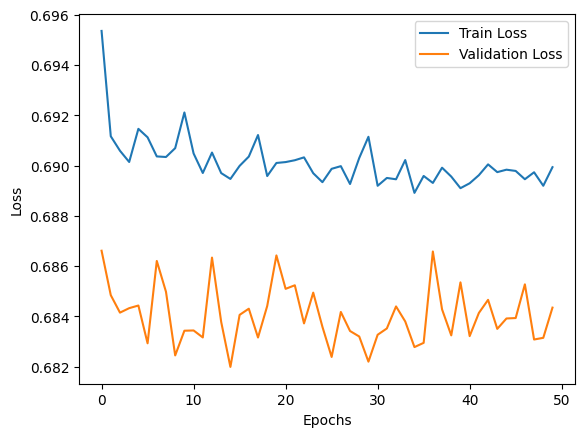

5/5 [==============================] - 0s 2ms/step
Results saved to 'LSTM_results.csv' successfully.


In [9]:
import pandas as pd
from binance import Client
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# Binance API credentials 
api_key = "5bb2b139e2f3693d8b35ca1f8252723355505d562b8e20625b513d0415f2a1e9"
api_secret = "7bbec5768461b201caba13b9605b0bc7fa0332a06f9480d5ef3405edd582ae80"
client = Client(api_key, api_secret)

# Get historical candlestick data
candlesticks = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1DAY, "1 Jan, 2021", "1 Jan, 2023")
# Create DataFrame from the candlestick data
df = pd.DataFrame(candlesticks, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close_Time',
                                         'Quote Asset Volume', 'Number_of_Trades', 'Taker Buy Base Volume',
                                         'Taker Buy Quote Volume', 'Ignore'])

# Drop unnecessary columns
columns_to_drop = ['Quote Asset Volume', 'Taker Buy Base Volume', 'Taker Buy Quote Volume', 'Ignore']
df.drop(columns=columns_to_drop, inplace=True)

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], unit='ms')

# Convert relevant columns to numeric
cols_to_numeric = ['Open', 'High', 'Low', 'Close', 'Volume']
df[cols_to_numeric] = df[cols_to_numeric].apply(pd.to_numeric)

# Function to calculate Exponential Moving Average (EMA)
def calculate_ema(data, window):
    ema = data.ewm(span=window, adjust=False).mean()
    return ema

# Function to calculate Relative Strength Index (RSI)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Function to calculate Bollinger Bands (BB)
def calculate_bb(data, window=14):
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    upper_band = rolling_mean + (2 * rolling_std)
    lower_band = rolling_mean - (2 * rolling_std)
    return upper_band, lower_band

# Calculate EMA, RSI, and Bollinger Bands
def calculate_indicators(df):
    df['EMA'] = calculate_ema(df['Close'], 55)
    df['RSI'] = calculate_rsi(df['Close'])
    df['Upper_Band'], df['Lower_Band'] = calculate_bb(df['Close'])

calculate_indicators(df)

# Implement the long and short strategies
def long_strategy(row):
    if row['RSI'] < 40 and row['Close'] > row['EMA'] and row['Close'] < row['Lower_Band']:
        return 1
    return 0

def short_strategy(row):
    if row['RSI'] > 60 and row['Close'] < row['EMA'] and row['Close'] > row['Upper_Band']:
        return -1
    return 0

df['Buy_Signal'] = df.apply(long_strategy, axis=1)
df['Sell_Signal'] = df.apply(short_strategy, axis=1)

# Save the DataFrame to a CSV file
df.to_csv('LSTM_signals.csv', index=False)
print("Data saved to 'LSTM_signals.csv' successfully.")

# Drop rows with missing values
df.dropna(inplace=True)
df.dropna(subset=['RSI'], inplace=True)

# Create 'target' column based on tomorrow's price
df["tomorrow"] = df["Close"].shift(-1)
df["target"] = (df["tomorrow"] > df["Close"]).astype(int)

# Remove irrelevant features
df_feature_selection = df.copy()
df_feature_selection.drop(columns=['Date', 'tomorrow', 'target', 'Close_Time', 'Number_of_Trades', 'Buy_Signal', 'Sell_Signal'], inplace=True)

# Check if any features remain after dropping constant features
if df_feature_selection.shape[1] == 0:
    raise ValueError("All features are constant. Please review your feature selection process.")

# Update cols_to_numeric based on the remaining columns after feature selection
cols_to_numeric = df_feature_selection.select_dtypes(include='float64').columns.tolist()

# Define features (X) and target (y) for feature selection
X_fs = df_feature_selection[cols_to_numeric].values
y_fs = df['target'].values

# Select features
selector = SelectKBest(score_func=f_classif, k='all')
X_fs_selected = selector.fit_transform(X_fs, y_fs)
selected_feature_indices = selector.get_support(indices=True)

# Check if the number of selected features exceeds the number of columns
if len(selected_feature_indices) <= 0:
    raise ValueError("No features selected. Please lower the value of k.")

# Limit k to the number of available features
k = min(k, len(selected_feature_indices))

# Update the feature names
selected_feature_names = df_feature_selection.columns[selected_feature_indices[:k]]

# Define features (X) and target (y) for training and testing sets
X = df[cols_to_numeric + ['EMA', 'RSI', 'Lower_Band', 'Upper_Band']].values
y = df['target'].values

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Select the top k features based on ANOVA F-value between features and target
selector = SelectKBest(score_func=f_classif, k=k)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Reshape the input data for LSTM (add a new axis)
X_train_selected = X_train_selected[:, :, np.newaxis]
X_test_selected = X_test_selected[:, :, np.newaxis]

# Define the create_model function with tunable hyperparameters
def create_model(learning_rate=0.001, lstm_units=64, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(X_train_selected.shape[1], X_train_selected.shape[2])))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


# Build the LSTM model with best hyperparameters
best_learning_rate = 0.001
best_lstm_units = 64
best_dropout_rate = 0.2
best_model = create_model(learning_rate=best_learning_rate, lstm_units=best_lstm_units, dropout_rate=best_dropout_rate)

# Train the model with the selected features and best hyperparameters
history = best_model.fit(X_train_selected, y_train, epochs=50, batch_size=10, validation_data=(X_test_selected, y_test))

# Evaluate the model
loss, accuracy = best_model.evaluate(X_test_selected, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

# Plot the learning curves
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Make predictions on the test set
y_pred_prob = best_model.predict(X_test_selected)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Actual_Target': y_test,
    'Predicted_Target': y_pred.flatten(),
    'Predicted_Probability': y_pred_prob.flatten()
})

# Save the results to a CSV file
results_df.to_csv('LSTM_results.csv', index=False)
print("Results saved to 'LSTM_results.csv' successfully.")
